# 3. Construa um regressor e identifique quais variáveis exercem maior impacto sobre o “target” e informe o porquê interpretando os resultados obtidos. 

* **métricas:** RMSE, R2 e cor(target_observado, target_predito);

* **dados:** regression_data.zip.

## 0.0. IMPORTS

In [47]:
import random
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import math
import xgboost as xgb

from pyod.models.knn import KNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.impute import KNNImputer
from dython.nominal import cramers_v
from matplotlib import pyplot as plt
from scipy.stats import boxcox
from category_encoders import MEstimateEncoder
from boruta import BorutaPy

### 0.1. Helper Functions

In [48]:
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: '%.2f' % x)

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display(HTML('<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()
    
def describe(df, stats):
    d = df.describe()
    return d.append(df.reindex(d.columns, axis = 1).agg(stats))

def ml_error (model_name, y, yhat):
    mae_list = []
    mape_list = []
    rmse_list = []
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    mae_list.append(mae)
    mape_list.append(mape)
    rmse_list.append(rmse)
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae_list,
                         'MAPE': mape_list,
                         'RMSE': rmse_list}, index=[0])

### 0.2. Loading Data

In [49]:
df_regression_raw_train = pd.read_csv('datasets/regression_train.csv')
df_regression_raw_test = pd.read_csv('datasets/regression_test.csv')

In [50]:
df_regression_raw_train.head()

,target,X1,X2,X3,X4,X5,X6,X7
0,NaN,-0.55,NaN,47.06,1.61,-65.88,0,-16.67
1,47.74,3.07,-2.84,49.40,0.26,-66.57,0,-6.66
2,NaN,-1.49,-13.10,42.37,3.99,-67.11,8,-30.79
3,908.20,6.91,-0.31,57.23,0.26,-66.18,5,-0.73
4,1640.46,1.92,3.46,51.70,2.46,-65.14,5,8.13


## 1.0. PASSO 01 - DESCRIÇÃO DOS DADOS

In [51]:
df1 = df_regression_raw_train.copy()
df_test = df_regression_raw_test.copy()

### 1.1. Data Info

In [52]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1042 entries, 0 to 1041
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   target  715 non-null    float64
 1   X1      1042 non-null   float64
 2   X2      1031 non-null   float64
 3   X3      1042 non-null   float64
 4   X4      1042 non-null   float64
 5   X5      1042 non-null   float64
 6   X6      1042 non-null   int64  
 7   X7      1042 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 65.2 KB


In [53]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261 entries, 0 to 260
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   target  180 non-null    float64
 1   X1      261 non-null    float64
 2   X2      261 non-null    float64
 3   X3      261 non-null    float64
 4   X4      261 non-null    float64
 5   X5      261 non-null    float64
 6   X6      261 non-null    int64  
 7   X7      261 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 16.4 KB


### 1.2. Check NA

In [54]:
df1.isnull().sum()

target    327
X1          0
X2         11
X3          0
X4          0
X5          0
X6          0
X7          0
dtype: int64

### 1.3. Fillout NA

In [55]:
imputer = KNNImputer(n_neighbors=5)
df1 = pd.DataFrame(imputer.fit_transform(df1),columns = df1.columns)
df_test = pd.DataFrame(imputer.fit_transform(df_test),columns = df_test.columns)

**1.** Para preenchimento de NA foi utilizado o KNNimputer

### 1.4. Estatística Descritiva

In [56]:
num_attributes = df1.select_dtypes (include = ['float64', 'int64'])

#### 1.4.1. Atributos Numéricos

In [57]:
describe(df1, ['skew', 'kurt'])

,target,X1,X2,X3,X4,X5,X6,X7
count,1042.00,1042.00,1042.00,1042.00,1042.00,1042.00,1042.00,1042.00
mean,985.07,2.42,-0.45,52.09,2.46,-65.28,4.38,-1.29
std,1470.85,3.18,4.42,31.37,2.54,9.03,3.29,11.07
min,0.06,-8.70,-13.65,38.04,0.00,-121.45,0.00,-69.84
25%,34.79,0.17,-3.29,47.09,0.67,-69.13,0.00,-7.83
50%,340.18,2.51,-0.44,49.97,1.65,-65.36,5.00,-1.07
75%,1381.87,4.54,2.40,52.67,3.36,-61.19,8.00,5.66
max,10382.47,12.38,12.93,500.00,18.81,53.92,8.00,30.38
skew,2.52,-0.06,0.05,14.00,1.98,1.72,-0.32,-0.57
kurt,7.90,-0.05,0.16,197.64,5.38,32.57,-1.48,3.25


### 1.5. Outliers

In [58]:
detector = KNN()
detector.fit(df1.iloc[:,1:7])

KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

In [59]:
outlier = detector.labels_
np.unique(outlier, return_counts=True)

(array([0, 1]), array([937, 105], dtype=int64))

In [60]:
outliers = []
for i in range(len(outlier)):
    if outlier[i] == 1:
        outliers.append(i)

In [61]:
df1 = df1.drop(labels=outliers, axis=0)

**1.** Foi utilizado um algoritmo KNN para identificar a distancia entre valores do dataframe e, assim, identificar outliers.

**2.** Os outliers foram removidos do dataframe.

## 2.0. ANÁLISE EXPLORATÓRIA DE DADOS

In [62]:
df2 = df1.copy()

### 2.1. Análise Univariada

#### 2.1.1. Variável Resposta

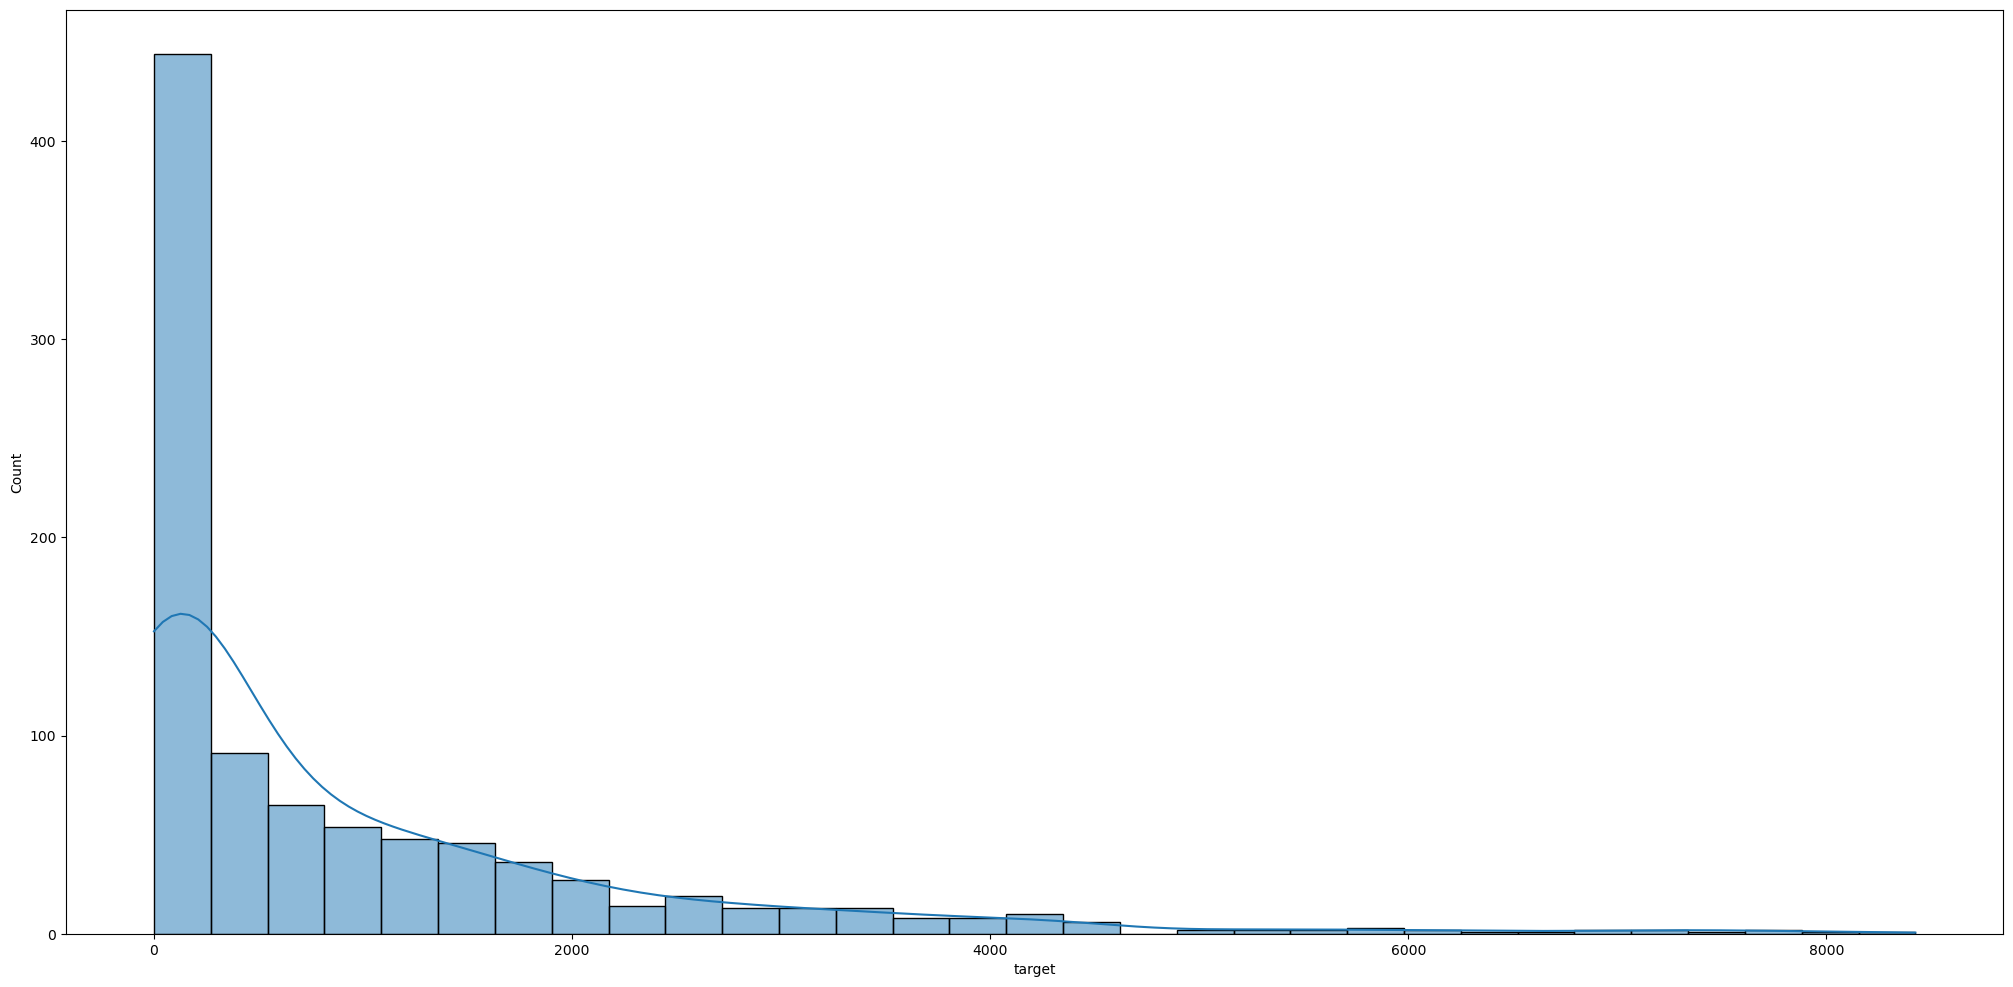

In [63]:
plt.rcParams['figure.figsize'] = [25, 12]
sns.histplot(df2['target'], kde = True);

#### 2.1.2. Variáveis Numéricas

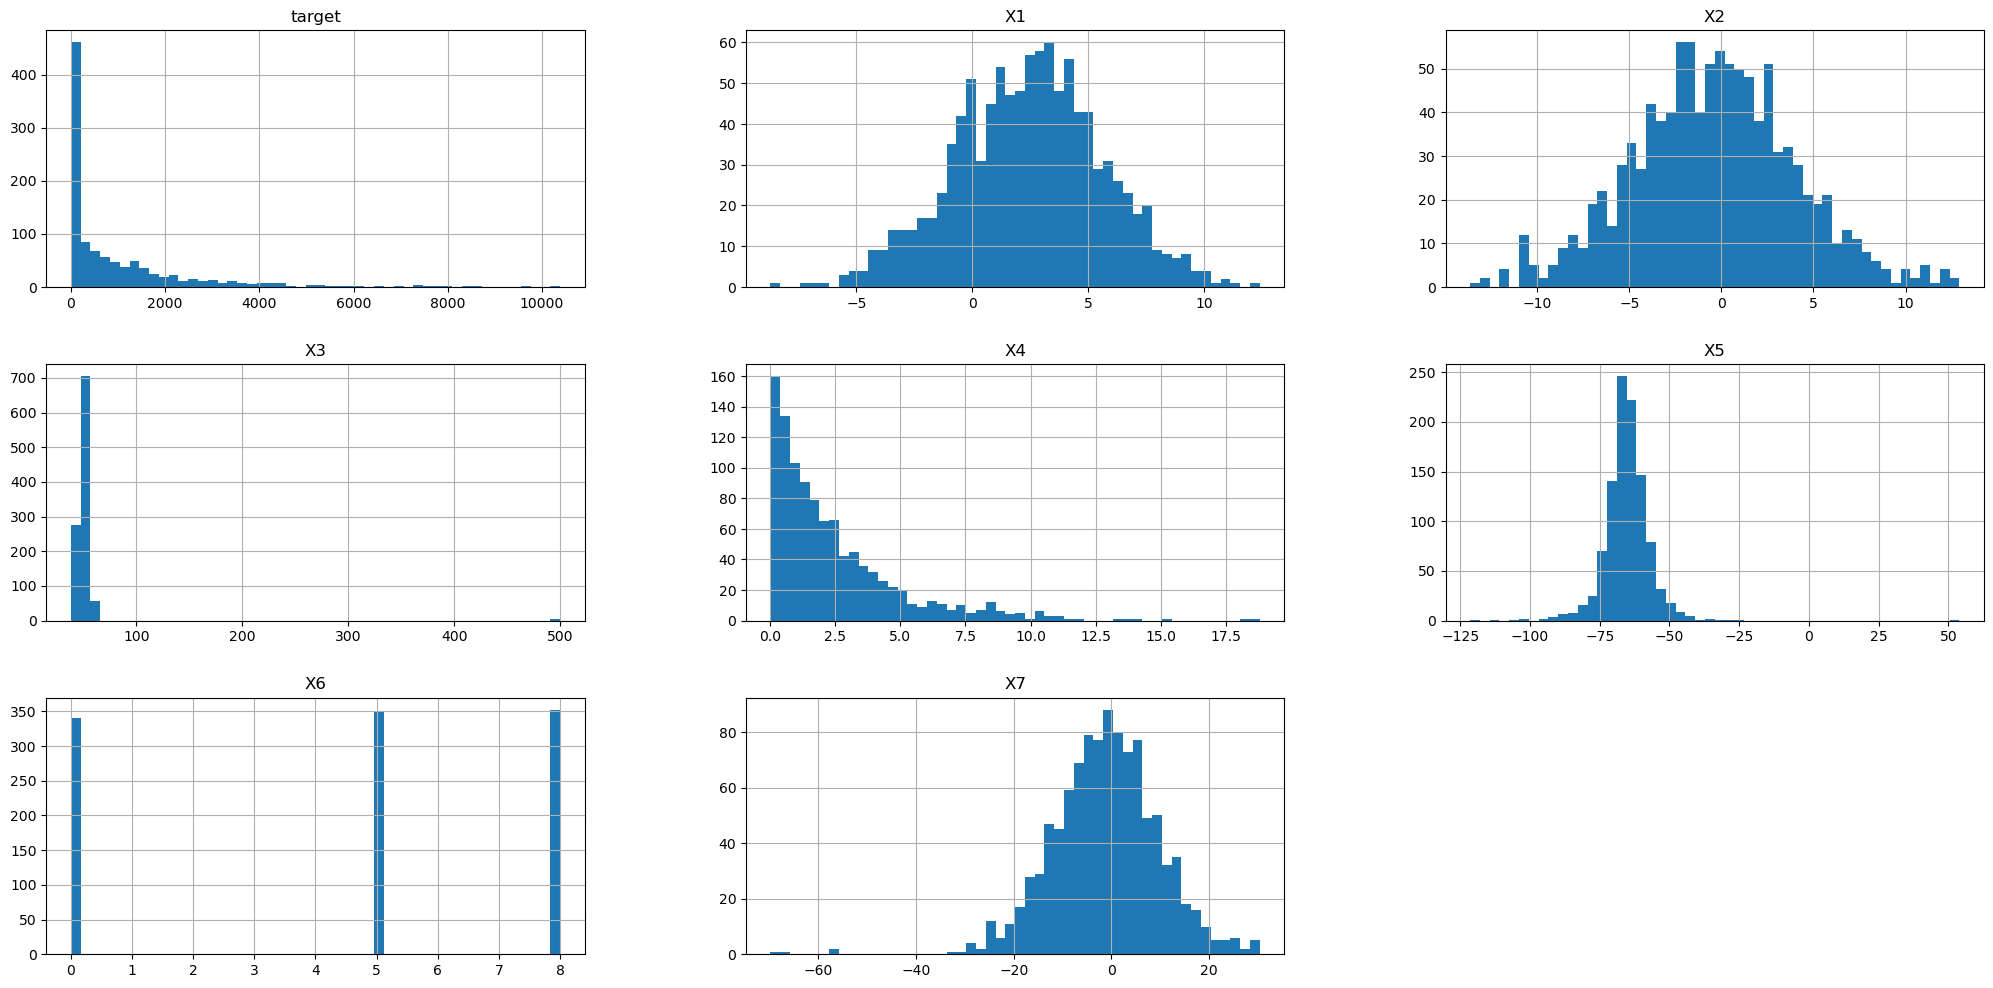

In [64]:
num_attributes.hist (bins = 50);

### 2.2. Análise Multivariada

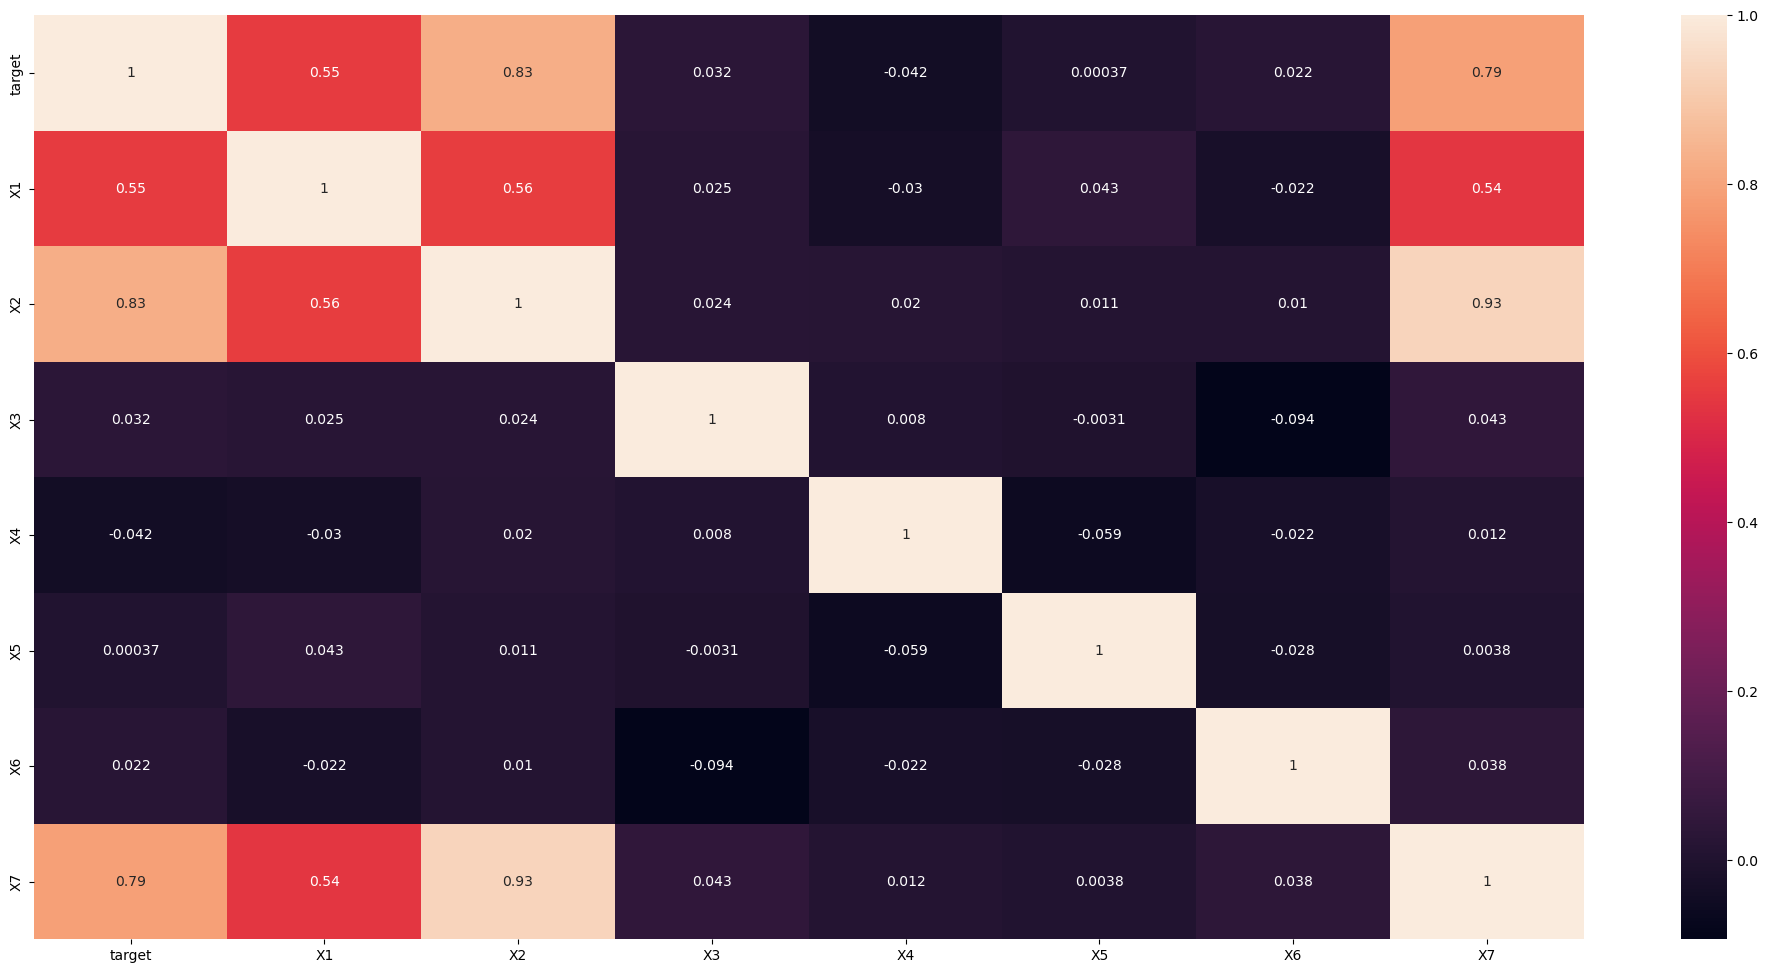

In [65]:
correlation = num_attributes.corr (method = 'pearson')
sns.heatmap (correlation, annot = True);

## 3.0. PASSO 03 - PREPAÇARAÇÃO DOS DADOS

In [66]:
df3 = df2.copy()

### 3.1. Rescaling

In [67]:
mms = MinMaxScaler()

# X1
df3['X1'] = mms.fit_transform (df3[['X1']].values)

# X2
df3['X2'] = mms.fit_transform (df3[['X2']].values)

# X3
df3['X3'] = mms.fit_transform (df3[['X3']].values)

# X4
df3['X4'] = np.cbrt(df3['X4'])
df3['X4'] = mms.fit_transform (df3[['X4']].values)

# X5
df3['X5'] = mms.fit_transform (df3[['X5']].values)

# X6
df3['X6'] = mms.fit_transform (df3[['X6']].values)

# X7
df3['X7'] = mms.fit_transform (df3[['X7']].values)

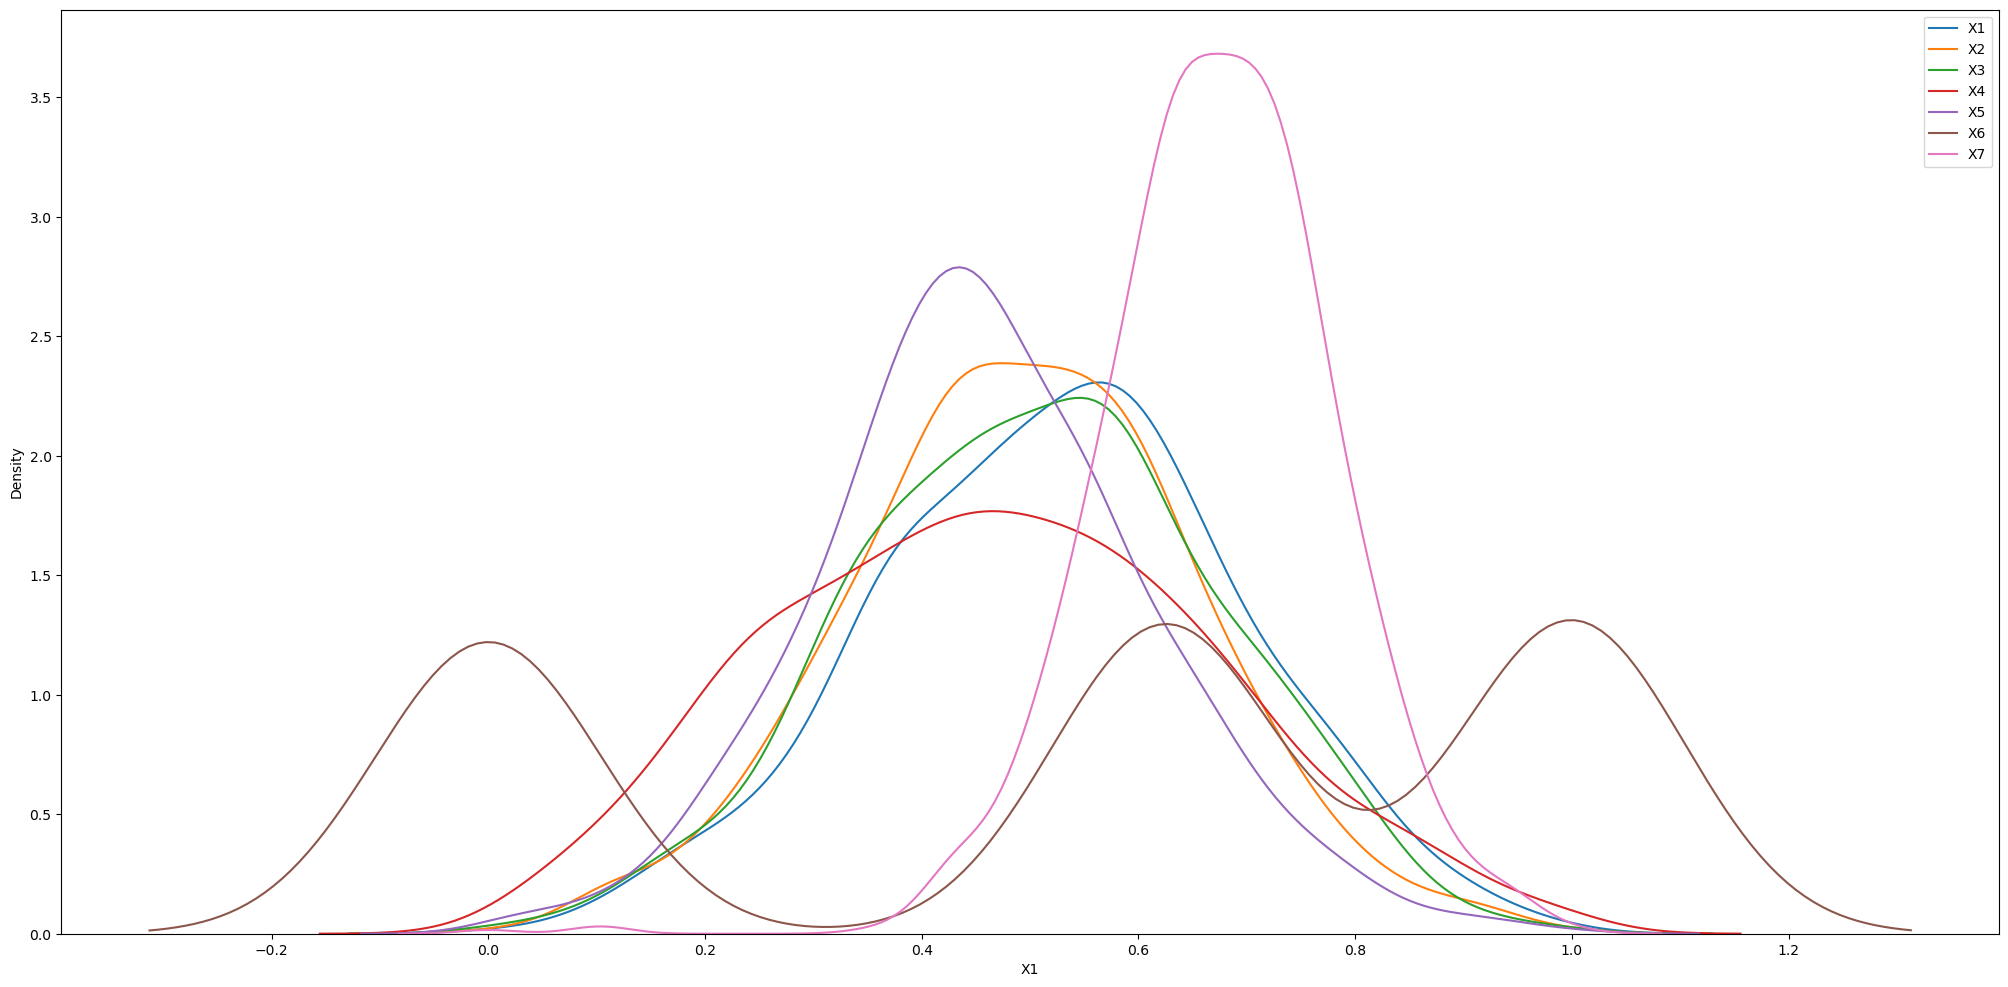

In [68]:
sns.kdeplot(df3['X1'], label = 'X1')
sns.kdeplot(df3['X2'], label = 'X2')
sns.kdeplot(df3['X3'], label = 'X3')
sns.kdeplot(df3['X4'], label = 'X4')
sns.kdeplot(df3['X5'], label = 'X5')
sns.kdeplot(df3['X6'], label = 'X6');
sns.kdeplot(df3['X7'], label = 'X7');
plt.legend(loc='upper right'); 

### 3.2. Transformação

#### 3.2.1 Variável Resposta

In [69]:
df3['target'] = np.log1p(df3['target'])

<AxesSubplot: xlabel='target', ylabel='Density'>

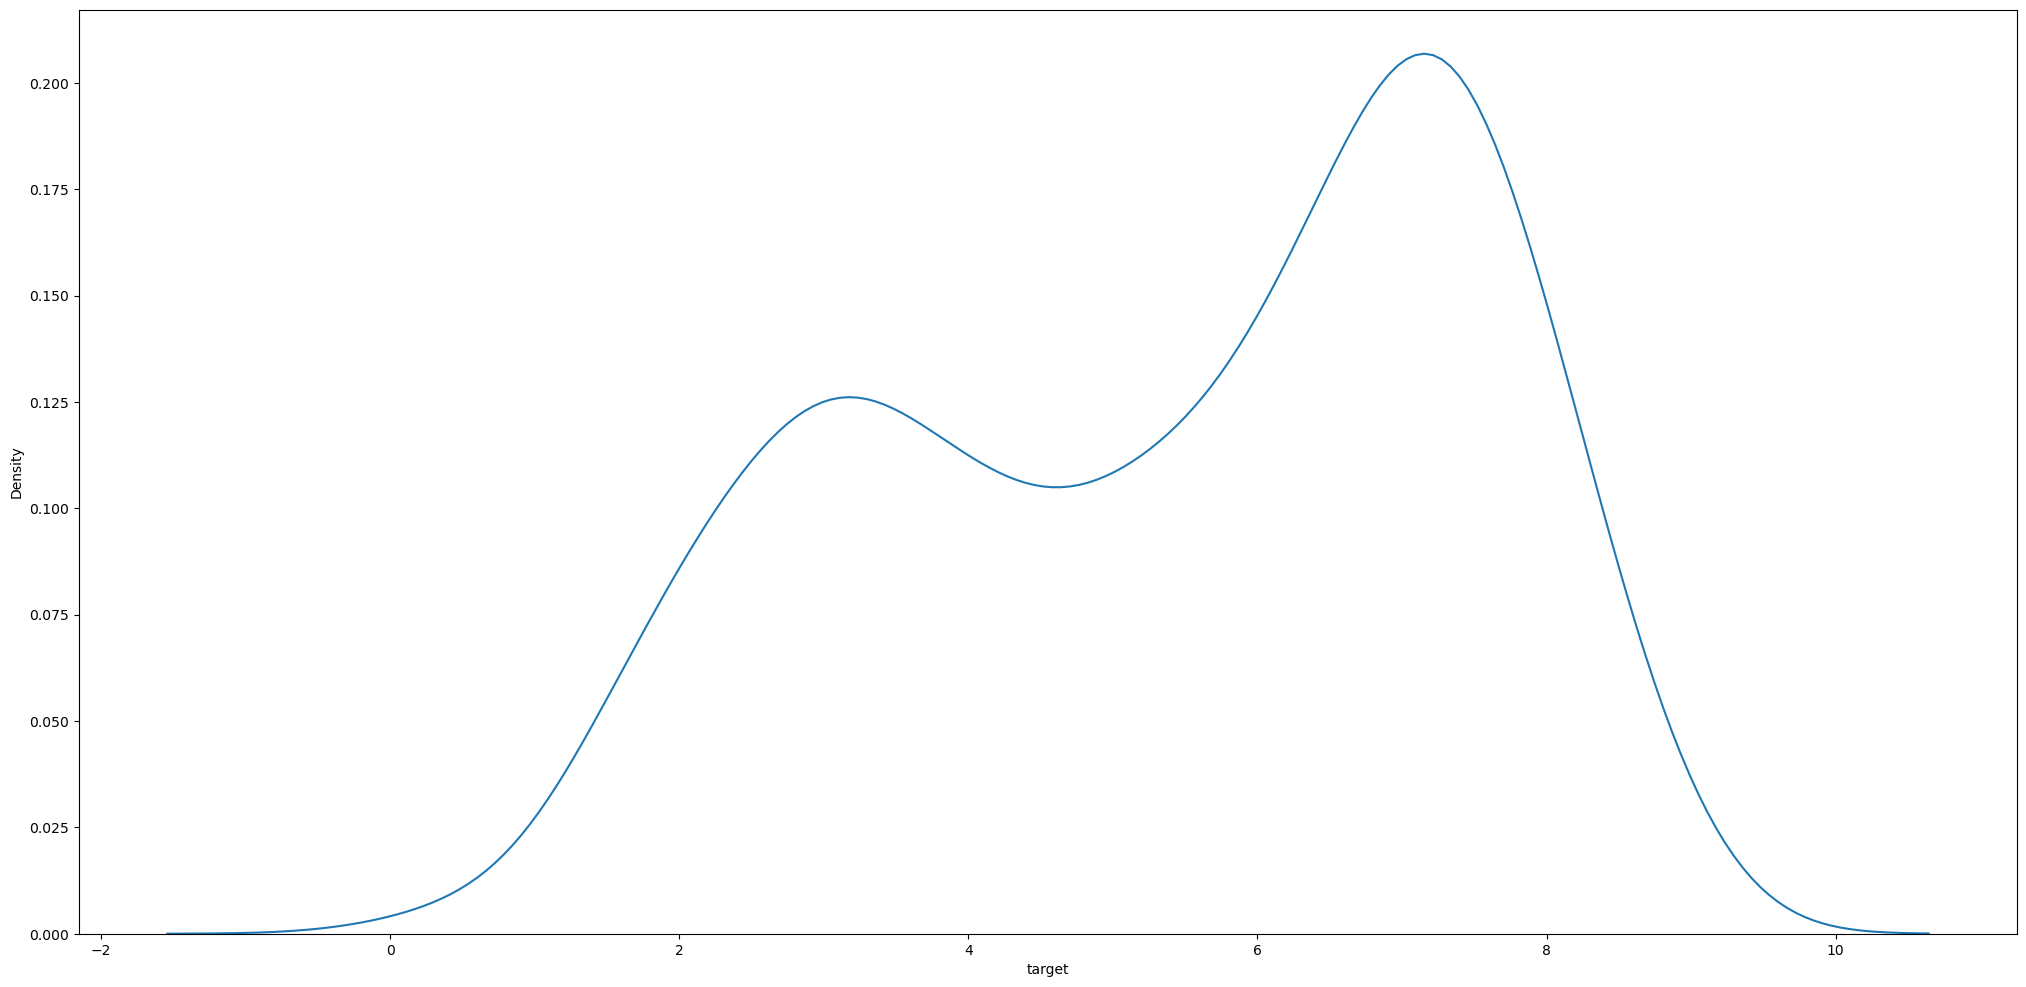

In [70]:
sns.kdeplot(df3['target'])

**1.** A variável resposta não apresentou uma distribuição normal mesmo após as transformações.

## 4.0. PASSO 04 - FEATURE SELECTION

In [71]:
df4 = df3.copy()

In [72]:
# train
y_train = df4['target']

# test
y_test = df_test['target']

### 4.1. Boruta Feature Selection

In [73]:
# train and test dataset for Boruta
x_train_n = df4.drop ('target', axis = 1).values
y_train_n = y_train.values.ravel()

# define RandomForestRegressor
rf = RandomForestRegressor (n_jobs = -1)

# define boruta
boruta = BorutaPy (rf, n_estimators = 'auto', verbose = 2, random_state = 10).fit(x_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	7
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	7
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	7
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	7
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	7
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	7
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	7
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	6
Tentative: 	0
Rejected: 	1


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	6
Tentative: 	0
Rejected: 	1


### 4.2. Features Selecionadas Boruta

In [74]:
cols_selected = boruta.support_.tolist()

x_train_fs = df4.drop('target', axis = 1)
cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()

cols_not_selected_boruta = list(np.setdiff1d (x_train_fs.columns, cols_selected_boruta))

In [75]:
cols_selected_boruta_full = cols_selected_boruta.copy()
feat_to_add = ['target']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

In [76]:
cols_selected_boruta_full

['X1', 'X2', 'X3', 'X4', 'X5', 'X7', 'target']

## 5.0. Modelo de Machine Learing

In [77]:
X_train = df4[cols_selected_boruta]
X_test = df_test[cols_selected_boruta]

### 5.1. Rescaling Test Data

In [78]:
# X1
X_test['X1'] = mms.fit_transform (X_test[['X1']].values)

# X2
X_test['X2'] = mms.fit_transform (X_test[['X2']].values)

# X3
X_test['X3'] = mms.fit_transform (X_test[['X3']].values)

# X4
X_test['X4'] = np.cbrt(X_test['X4'])
X_test['X4'] = mms.fit_transform (X_test[['X4']].values)

# X7
X_test['X7'] = mms.fit_transform (X_test[['X7']].values)

### 5.1. XGBoost Regressor

In [79]:
# model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                              n_estimators=100,
                              eta=0.01,
                              max_depth=10,
                              subsample=0.7,
                              colsample_bytree=0.9 ).fit(X_train, y_train)
# prediction
yhat_xgb = model_xgb.predict(X_test)

# performance
xgb_result = ml_error('XGBoost Regressor', y_test, np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,748.83,0.96,1333.42


In [80]:
# model
rf = RandomForestRegressor(n_estimators = 100, n_jobs = -1, random_state = 10).fit(X_train, y_train)

# prediction
yhat_rf = rf.predict(X_test)

# performance
rf_result = ml_error ('Random Forest Regressor', y_test, np.expm1(yhat_xgb))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,748.83,0.96,1333.42


## 6.0. PASSO 06 - HYPERPARAMETER FINE TUNING

### 6.1. Random Search

In [81]:
param = {'n_estimators': [1500, 1700, 2500, 3000, 3500],
         'eta': [0.01, 0.03],
         'max_depth': [3, 5, 9],
         'subsample': [0.1, 0.5, 0.7],
         'colsample_bytree': [0.3, 0.7, 0.9],
         'min_child_weight': [3, 8, 15]}
MAX_EVAL = 10

In [82]:
#final_result = pd.DataFrame()
#xgb_result = []
#
#for i in range(MAX_EVAL):
#    # choose values for parameters randomly
#    hp = {k: random.sample(v, 1)[0] for k, v in param.items()}
#    print(hp)
#    # model
#    model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
#    n_estimators=hp['n_estimators'],
#    eta=hp['eta'],
#    max_depth=hp['max_depth'],
#    subsample=hp['subsample'],
#    colsample_bytree=hp['colsample_bytree'],
#    min_child_weight=hp['min_child_weight']).fit(X_train, y_train)
#    
#    # prediction
#    yhat_xgb = model_xgb.predict(X_test)
#
#    # performance
#    xgb_result = ml_error('XGBoost Regressor', y_test, np.expm1(yhat_xgb))
#    final_result = pd.concat([final_result, xgb_result])

In [83]:
#final_result

**1.** Foi utilizado o Random Search para encontrar a combinação de parâmetros para o XGBoost com menor erro.

In [84]:
# model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                              n_estimators=3500,
                              eta=0.01,
                              max_depth=5,
                              subsample=0.1,
                              colsample_bytree=0.9,
                              min_child_weight=8).fit(X_train, y_train)
# prediction
yhat_xgb = model_xgb.predict(X_test)

# performance
xgb_result = ml_error('XGBoost Regressor', y_test, np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,169.21,0.72,346.92


In [85]:
cv_score = cross_val_score(estimator=model_xgb, X=X_train, y=y_train, cv=10)

In [86]:
r2_score_test = r2_score(y_test, yhat_xgb)

In [87]:
print('RMSE: ', xgb_result['RMSE'])
print('CV *R2_score (train): ', cv_score.mean())
print("R2_score (test): ", r2_score_test)

RMSE:  0   346.92
Name: RMSE, dtype: float64
CV *R2_score (train):  0.9384963475969037
R2_score (test):  -0.48173087887822974


**1.** Resultados do algoritmo não foram bons.

**2.** Um dos motivos pode ser a distribuição não gaussiana da variável resposta. Não foi encontrado transformações que a deixassem em um aspecto melhor.

**3.** Para próximos passos, a prioridade seria encontrar uma transformação capaz de gerar uma variável resposta com uma distribuição normalizada.